#### Import needed libraries

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import spacy
import string
import sklearn
from spacy import displacy
from pathlib import Path
from spacy import displacy
import os
from collections import Counter
import nltk
# Download the stopwords and tokenizer from nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from google.colab import drive
drive.mount('/content/drive')


# Load the English language model
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Downloading class dataset

In [2]:
# stored in my google drive
!unzip -q /content/drive/MyDrive/Colab\ Notebooks/datasets/BBC\ News\ Summary-kaggle-v2.zip

#### Importing and converting data to panda data frame

In [3]:
classes = os.listdir('/content/BBC News Summary/News Articles')
Articles_dir = '/content/BBC News Summary/News Articles/'

# initializing feature column data types
articles = []
file_arr = []
is_sport = []
is_biz = []
is_ent = []
is_politics = []
is_tech =[]
labels = []
for cls in classes:
    files = os.listdir(Articles_dir + cls)

    for file in files:
        article_file_path = Articles_dir + cls + '/' + file

        # Starting to append values for the different feature columns
        # extracting data from files
        try:
            with open (article_file_path,'r') as f:
                articles.append('.'.join([line.rstrip() for line in f.readlines()]))

            file_arr.append(cls + '/' + file)
            labels.append(cls)
            match cls:
              case "sport":
                is_sport.append(1)
                is_biz.append(0)
                is_ent.append(0)
                is_politics.append(0)
                is_tech.append(0)
              case "tech":
                is_sport.append(0)
                is_biz.append(0)
                is_ent.append(0)
                is_politics.append(0)
                is_tech.append(1)
              case "business":
                is_sport.append(0)
                is_biz.append(1)
                is_ent.append(0)
                is_politics.append(0)
                is_tech.append(0)
              case "entertainment":
                is_sport.append(0)
                is_biz.append(0)
                is_ent.append(1)
                is_politics.append(0)
                is_tech.append(0)
              case "politics":
                is_sport.append(0)
                is_biz.append(0)
                is_ent.append(0)
                is_politics.append(1)
                is_tech.append(0)
        except:
            pass

df = pd.DataFrame({'File_path':file_arr,'Articles text': articles, 'label': labels, 'Business': is_biz, 'Entertainment': is_ent, 'Politics': is_politics, 'Sport': is_sport, 'Tech': is_tech})
df.head()

,File_path,Articles text,label,Business,Entertainment,Politics,Sport,Tech
0,sport/487.txt,Officials respond in court row..Australian ten...,sport,0,0,0,1,0
1,sport/257.txt,Spain coach faces racism inquiry..Spain's Foot...,sport,0,0,0,1,0
2,sport/471.txt,Capriati out of Australian Open..Jennifer Capr...,sport,0,0,0,1,0
3,sport/252.txt,Ferguson rues failure to cut gap..Boss Sir Ale...,sport,0,0,0,1,0
4,sport/158.txt,Stam spices up Man Utd encounter..AC Milan def...,sport,0,0,0,1,0


## 2. Data Cleaning and Appending


Preprocessing data is essentially to getting optimal model results. I used a modular approach and created a function to process each "Articles text" entry in the data.  I first began with tokenizing the text which, I noticed, better helped identify sets of words and distinguish puntuation more properly. I followed by lowercasing all the words and removing the following: punctuation, stopwords, and duplicate words.

The process_text function returns the clean data as "processed_text" and gets added as a new data column. I also reused another function called get_token_count, to return and add a count of the tokens of the original Articles text and processed_text. This gave me great initial insight to see how much information was reduced, and to see how much was relevent.

In [67]:
def preprocess_text(text):
    # Convert text to lowercase
    words = word_tokenize(text)

    # Convert words to lowercase
    words = [word.lower() for word in words]

    # Remove punctuation from words
    words = [word for word in words if word.isalnum()]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove duplicate words
    unique_words = list(dict.fromkeys(words))

    # Join the words back into a string
    text = ' '.join(unique_words)

    return text

def get_token_count(text):
    words = word_tokenize(text)
    return len(words)


# Apply the function to the DataFrame column
df['processed_text'] = df['Articles text'].apply(preprocess_text)
df['processed_text_token_count'] = df['processed_text'].apply(get_token_count)
df['Articles_text_token_count'] = df['Articles text'].apply(get_token_count)

display(df.head())
print("sample of cleaned text \n", df['processed_text'][0])

,File_path,Articles text,label,Business,Entertainment,Politics,Sport,Tech,processed_text,processed_text_token_count,Articles_text_token_count
0,sport/487.txt,Officials respond in court row..Australian ten...,sport,0,0,0,1,0,officials respond court row australian tennis ...,80,247
1,sport/257.txt,Spain coach faces racism inquiry..Spain's Foot...,sport,0,0,0,1,0,spain coach faces racism inquiry football fede...,106,288
2,sport/471.txt,Capriati out of Australian Open..Jennifer Capr...,sport,0,0,0,1,0,capriati australian open jennifer become third...,57,146
3,sport/252.txt,Ferguson rues failure to cut gap..Boss Sir Ale...,sport,0,0,0,1,0,ferguson rues failure cut gap boss sir alex le...,78,220
4,sport/158.txt,Stam spices up Man Utd encounter..AC Milan def...,sport,0,0,0,1,0,stam spices man utd encounter ac milan defende...,146,447


sample of cleaned text 
 officials respond court row australian tennis top official defended open courts melbourne park criticism playing surface lleyton hewitt said gutful trying persuade make faster australia geoff pollard rejected comments ask made last year knowledge spent substantial amount money modifications got past fourth round seven attempts earlier worthy prestigious tournament would play whatever order chance winning starts 17 january speeded since following complaints several players refused accept may bearing performances years proving versatile surfaces one beat roger federer davis cup 2003


#### EDA of Articles Text using NER and POS

In [55]:
doc = nlp(df['processed_text'][0])

# produce spacy ent results
displacy.render(doc, style='ent', minify=True, jupyter=True)

options = {"compact": True, "bg": "#09a3d5","color": "white", "font": "Source Sans Pro", "distance": 70}
displacy.render(doc, style="dep",minify=True,jupyter=True, options=options)


#### Initial Inisight on Label Distribution

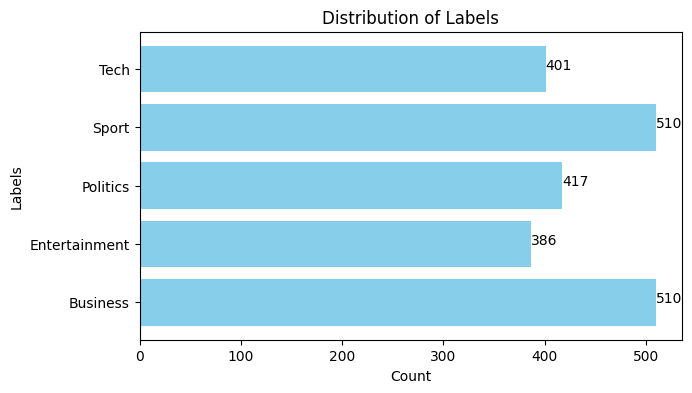

In [66]:
labels = ['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']
counts = [df[label].sum() for label in labels]

plt.figure(figsize=(7, 4))
plt.barh(labels, counts, color='skyblue', label="hi")
for index, value in enumerate(counts):
    plt.text(value, index, str(value))
plt.xlabel('Count')
plt.ylabel('Labels')
plt.title('Distribution of Labels')
plt.show()

## Train, test split

This dataset was more complex than the assignment because it dealt with multiple labels of features compared to just one. One of the biggest issues was understanding how to reshape the values prior to training so that the y values could produce results for multiple columns and not just one.

This was done by reshapeing the processed_text to match the shape of the multiple columns data (y).

In [72]:
X = df['processed_text'].values
y = df[['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']].values

# Convert X to a NumPy array of shape (n_samples, 1) to match y's shape of (n_samples, n_labels)
# y.shape (2224, 5)
X = np.array(X).reshape(-1, 1)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print("Label distribution in test set:", np.sum(y_test, axis=0))
print("Label distribution in entire dataset:", np.sum(y, axis=0))

# Reshape to reshape nparrays from 2d to 1d for vectorization
X_train = X_train.reshape(-1)
X_test = X_test.reshape(-1)


Label distribution in test set: [129  92  91 143 101]
Label distribution in entire dataset: [510 386 417 510 401]


## Apply TF-IDF Vectorization


To apply TF-IDF Vectorization

In [24]:
# Step 3:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

display(X_test_tfidf)

<556x24922 sparse matrix of type '<class 'numpy.float64'>'
	with 80786 stored elements in Compressed Sparse Row format>

## Apply SVM and Random Forest

OneVsRestClassifier is a simple and effective method for adapting binary classifiers for multi-class or multi-label problems, but it may not always be the most efficient in terms of computation and memory usage, especially when the number of classes is large.

In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and one classifier only, it is possible to gain knowledge about the class by inspecting its corresponding classifier (sklearn.multiclass.OneVsRestClassifier¶).

In [86]:
# Create a OneVsRestClassifier instance with a Support Vector Machine (SVM) classifier
svm_classifier = SVC(kernel='linear', random_state=42, probability=True)
clf = OneVsRestClassifier(svm_classifier)
# Fit the classifier
clf.fit(X_train_tfidf, y_train)
# Predictions on the test set
y_pred_tfidf = clf.predict(X_test_tfidf)

In [87]:
print("Results using TF-IDF Vectorization and Support Vector Machine (SVM) Classifier:")
eval_metrics(X_test_tfidf, y_test, y_pred_tfidf, clf)

Results using TF-IDF Vectorization and Support Vector Machine (SVM) Classifier:
Accuracy: 0.93
Precision: 0.99
Recall: 0.94
F1 Score: 0.96
AUC-ROC Score: 1.0
               precision    recall  f1-score   support

     Business       0.98      0.88      0.93       129
Entertainment       0.99      0.95      0.97        92
     Politics       0.99      0.90      0.94        91
        Sport       0.99      1.00      1.00       143
         Tech       0.98      0.95      0.96       101

    micro avg       0.99      0.94      0.96       556
    macro avg       0.99      0.94      0.96       556
 weighted avg       0.99      0.94      0.96       556
  samples avg       0.94      0.94      0.94       556

Confusion matrix for Business:
[[425   2]
 [ 15 114]]
Confusion matrix for Entertainment:
[[463   1]
 [  5  87]]
Confusion matrix for Politics:
[[464   1]
 [  9  82]]
Confusion matrix for Sport:
[[412   1]
 [  0 143]]
Confusion matrix for Tech:
[[453   2]
 [  5  96]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [88]:
# Create a OneVsRestClassifier instance with a RandomForestClassifier estimator
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
clf = OneVsRestClassifier(rf_classifier)

# Fit the classifier
clf.fit(X_train_tfidf, y_train)

# Make predictions
y_pred_tfidf_rfc = clf.predict(X_test_tfidf)

In [89]:
print("Results using TF-IDF Vectorization and Random Forest Classifier:")
eval_metrics(X_test_tfidf, y_test, y_pred_tfidf_rfc, clf)

Results using TF-IDF Vectorization and Random Forest Classifier:
Accuracy: 0.85
Precision: 0.99
Recall: 0.86
F1 Score: 0.92
AUC-ROC Score: 1.0
               precision    recall  f1-score   support

     Business       1.00      0.81      0.89       129
Entertainment       1.00      0.86      0.92        92
     Politics       1.00      0.76      0.86        91
        Sport       0.99      0.99      0.99       143
         Tech       0.99      0.83      0.90       101

    micro avg       0.99      0.86      0.92       556
    macro avg       0.99      0.85      0.91       556
 weighted avg       0.99      0.86      0.92       556
  samples avg       0.86      0.86      0.86       556

Confusion matrix for Business:
[[427   0]
 [ 25 104]]
Confusion matrix for Entertainment:
[[464   0]
 [ 13  79]]
Confusion matrix for Politics:
[[465   0]
 [ 22  69]]
Confusion matrix for Sport:
[[411   2]
 [  2 141]]
Confusion matrix for Tech:
[[454   1]
 [ 17  84]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Evaluate Metrics Function


Classification metrics were caputed to get ingsight:


1. Accuracy: Correct predictions over the total number of instances.
2. Precision: Measures the proportion of true positive predictions among the instances that the model predicted as positive.
3. Recall: Measures the proportion of true positive predictions among the actual positive instances. Measures ability to identify all relevant instances.4. F1 Score: Considers both false positives and false negatives, and is the mean score of precision and recall.
5. AUC-ROC Score: Tells how much the model is capable of distinguishing between classes.




The predict_proba() function was used and calculates a score for each class, and the class with the highest score is predicted as the output.

In order to get better insight on the accuracy of the classification model, a confusion matrix was performed on each of the feature columns. Since we were using binary classification for our labels, the different values represent the count of true negatives (at 0,0), false negatives (at 1,0), true positives (at 1,1), and false positives (at 0,1).

In [85]:
def eval_metrics(X_test_tfidf, y_test, y_pred_tfidf, clf):
  # Evaluate using classification metrics
  accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
  precision_tfidf = precision_score(y_test, y_pred_tfidf, average='weighted')
  recall_tfidf = recall_score(y_test, y_pred_tfidf, average='weighted')
  f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

  # Using predict_proba which peformed similar results to decision_function()
  roc_auc_tfidf = roc_auc_score(y_test, clf.predict_proba(X_test_tfidf))

  # Display the classification metrics
  print(f"Accuracy: {accuracy_tfidf:.2}")
  print(f"Precision: {precision_tfidf:.2}")
  print(f"Recall: {recall_tfidf:.2}")
  print(f"F1 Score: {f1_score_tfidf:.2}")
  print(f"AUC-ROC Score: {roc_auc_tfidf:.2}")

  labels = ['Business', 'Entertainment', 'Politics', 'Sport', 'Tech']
  # Report on classification metrics for each of the features
  print(classification_report(y_test, y_pred_tfidf, target_names=labels))

  for i, class_label in enumerate(labels):
      print(f"Confusion matrix for {class_label}:")
      print(confusion_matrix(y_test[:, i], y_pred_tfidf[:, i]))

References:

https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

## Applying Random Forest

In [ ]:
!jupyter nbconvert --to pdf